# Amazon Reviews: Natural Language Processing 

## Data Loading & Exploration

In [63]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')

In [64]:
data = pd.read_csv('./Reviews.csv')

data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Feature Engineering

In [65]:
data["Percentage_Helpful"] = np.where(
    data["HelpfulnessDenominator"] > 0,
    data["HelpfulnessNumerator"] / data["HelpfulnessDenominator"],
    -1,
)

data["Percentage_Bins"] = pd.cut(
    data["Percentage_Helpful"],
    bins=[-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0],
    labels=["Empty", "0-20%", "20-40%", "40-60%", "60-80%", "80-100%"],
)

In [66]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Percentage_Helpful,Percentage_Bins
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,NaN
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,NaN


In [67]:
data = data.groupby(["Score", "Percentage_Bins"]).agg({"Id": "count"}).reset_index()

In [68]:
data.pivot(index="Percentage_Bins", columns="Score")

Id                            
Score                1     2      3      4       5
Percentage_Bins                                   
Empty             8060  4234   5062   4780   11638
0-20%             2338   762    474    116     432
20-40%            4649  1618   1506    909    2275
40-60%            6586  3051   3384   3185   10312
60-80%            5838  2486   2754   2941   11060
80-100%          12531  7014  11037  26707  140661

### Visualization

<Axes: xlabel='Score', ylabel='Percentage_Bins'>

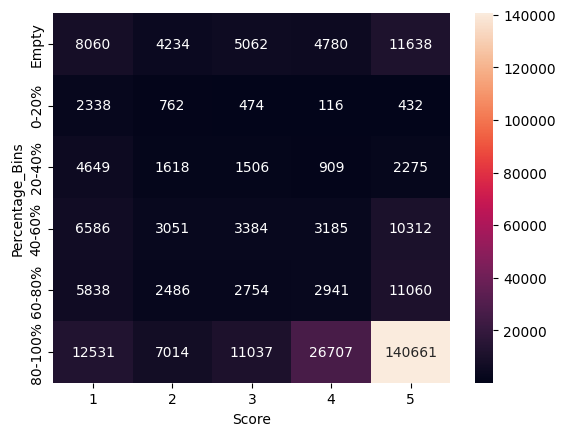

In [69]:
sns.heatmap(
    data.pivot(index="Percentage_Bins", columns="Score")["Id"], annot=True, fmt="d"
)

## ML-NLP

In [70]:
original_data = pd.read_csv('./Reviews.csv')

# Exclude neutral score
df = original_data[original_data["Score"] != 3]
X = df["Text"]
y_dict = {1: 0, 2: 0, 4: 1, 5: 1}
y = df["Score"].map(y_dict)

### Word2Vec

In [71]:
from sklearn.feature_extraction.text import CountVectorizer

c = CountVectorizer(stop_words = 'english') # stop_words = 'english' removes common words like 'the', 'a', 'an', etc.
X_c = c.fit_transform(X)

In [72]:
print('features: {}'.format(X_c.shape[1]))

features: 114969


In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_c, y)
print(' train records: {}'.format(X_train.shape[0]))

log = LogisticRegression()

ml = log.fit(X_train, y_train)
acc = ml.score(X_test, y_test)

print("Model Accuracy: {}".format(acc))

 train records: 394360
Model Accuracy: 0.9371034734583961


#### View Top 5 Positive & Top 5 negative words

In [74]:
w = c.get_feature_names_out() # get the words used in the model.
coef = ml.coef_.tolist()[0] # get the coefficients of the model

coef_df = pd.DataFrame({"Word": w, "Coefficient": coef})

coef_df = coef_df.sort_values(["Coefficient", "Word"], ascending=False)

In [75]:
print("-Top 20 positive-")
print(coef_df.head(20).to_string(index=False))
print("\n")
print("-Top 20 negative-")
print(coef_df.tail(20).to_string(index=False))

-Top 20 positive-
      Word  Coefficient
pleasantly     3.775995
  downside     3.171503
 addicting     2.963913
 skeptical     2.698764
    hooked     2.608958
    resist     2.401741
    delish     2.295262
  drawback     2.263858
   worries     2.176166
 excellent     2.148602
 delighted     2.144827
  soothing     2.116235
  terrific     2.103860
     penny     2.077154
   perfect     1.994557
     holds     1.991882
  hesitant     1.988897
   welcome     1.976772
    brings     1.956225
   easiest     1.950760


-Top 20 negative-
          Word  Coefficient
        bummer    -2.334036
         ruins    -2.348238
       defeats    -2.367676
       allegro    -2.377608
      terrible    -2.406612
disappointment    -2.442205
       glowing    -2.457148
   unappealing    -2.564299
    overpowers    -2.579469
         lousy    -2.709415
   embarrassed    -2.920224
        ripoff    -2.969976
    returnable    -3.022010
     cancelled    -3.044287
      mediocre    -3.062919
 disappoin

### NLP Automation

In [76]:
def text_fit(X, y, nlp_model,ml_model,coef_show=1):
    X_c = nlp_model.fit_transform(X)
    print('features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y)
    print(' train records: {}'.format(X_train.shape[0]))
    print(' test records: {}'.format(X_test.shape[0]))
    ml =ml_model.fit(X_train, y_train)
    acc = ml.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))
    
    if coef_show == 1: 
        w = nlp_model.get_feature_names_out()
        coef = ml.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('\n')
        print('-Top 5 positive-')
        print(coeff_df.head(5).to_string(index=False))
        print('\n')
        print('-Top 5 negative-')        
        print(coeff_df.tail(5).to_string(index=False))

In [77]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

c = CountVectorizer(stop_words = 'english')
log = LogisticRegression()

text_fit(X, y, c, log)

features: 114969
 train records: 394360
 test records: 131454
Model Accuracy: 0.9363047149573235


-Top 5 positive-
      Word  Coefficient
pleasantly     4.251667
  downside     3.543465
 addicting     3.059885
 skeptical     3.011605
  soothing     2.468265


-Top 5 negative-
       Word  Coefficient
     ripoff    -2.904487
  cancelled    -3.001201
 returnable    -3.080141
  deceptive    -3.816741
undrinkable    -3.835468


### Predict function

In [78]:
from sklearn.metrics import confusion_matrix,accuracy_score
def predict(X, y, nlp_model,ml_model):
    
    X_c = nlp_model.fit_transform(X)
    print('features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y)
    print(' train records: {}'.format(X_train.shape[0]))
    print(' test records: {}'.format(X_test.shape[0]))
    ml =ml_model.fit(X_train, y_train)
    predictions=ml.predict(X_test)
    cm=confusion_matrix(predictions,y_test)
    print(cm)
    acc=accuracy_score(predictions,y_test)
    print(acc)

In [79]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

c = CountVectorizer(stop_words = 'english')
lr=LogisticRegression()

predict(X, y, c, lr)

features: 114969
 train records: 394360
 test records: 131454
[[ 14976   2949]
 [  5442 108087]]
0.9361677849285681


### Try on Dummy Data

In [80]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

text_fit(X, y, c, DummyClassifier(),0)

tfidf = TfidfVectorizer(stop_words="english")
text_fit(X, y, tfidf, LogisticRegression())

features: 114969
 train records: 394360
 test records: 131454
Model Accuracy: 0.842705433079252
features: 114969
 train records: 394360
 test records: 131454
Model Accuracy: 0.9338475816635478


-Top 5 positive-
     Word  Coefficient
    great    14.014445
     best    12.443800
delicious    12.058217
  perfect    10.558667
    loves     9.570948


-Top 5 negative-
          Word  Coefficient
  disappointed    -8.644732
disappointment    -8.915198
      terrible    -9.434258
 disappointing    -9.880078
         worst   -12.102672


### Oversampling Problem

We will be focusing on score 5 reviews, and get rid of comments with neutral votes

In [84]:
df["Percentage_Helpful"] = np.where(
	df["HelpfulnessDenominator"] > 0,
	df["HelpfulnessNumerator"] / df["HelpfulnessDenominator"],
	-1,
)

df["Percentage_Bins"] = pd.cut(
	df["Percentage_Helpful"],
	bins=[-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0],
	labels=["Empty", "0-20%", "20-40%", "40-60%", "60-80%", "80-100%"],
)

df2 = df[df['Score'] == 5]
data2 = df2[df2["Percentage_Bins"].isin(["0-20%", "20-40%", "60-80%", "80-100%"])] # exclude empty and 40-60% bins as they are neutral

In [85]:
X = data2["Text"]
y_dict = {"0-20%": 0, "20-40%": 0, "60-80%": 1, "80-100%": 1}
y = data2["Percentage_Bins"].map(y_dict)

In [86]:
print(y.value_counts())

Percentage_Bins
1.0    151721
0.0      2707
Name: count, dtype: int64


In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


tf = TfidfVectorizer()
X_c = tf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_c, y, train_size=0.7)

In [88]:
y_test.value_counts()

Percentage_Bins
1.0    45504
0.0      825
Name: count, dtype: int64

In [90]:
from imblearn.over_sampling import RandomOverSampler

os = RandomOverSampler()

X_train_res, y_train_res = os.fit_resample(X_c, y)
X_train_res.shape, y_train_res.shape

((303442, 67507), (303442,))

In [92]:
from collections import Counter

print("Original dataset shape {}".format(Counter(y)))
print("Resampled dataset shape {}".format(Counter(y_train_res)))

Original dataset shape Counter({1.0: 151721, 0.0: 2707})
Resampled dataset shape Counter({1.0: 151721, 0.0: 151721})


In [93]:
from sklearn.linear_model import LogisticRegression

log_class = LogisticRegression()

grid = {"C": 10.0 ** np.arange(-2, 3), "penalty": ["l1", "l2"]}

In [94]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(estimator=log_class, param_grid=grid, cv=5, n_jobs=-1, scoring="f1_macro")
clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)

In [95]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  825     0]
 [  903 44601]]
              precision    recall  f1-score   support

         0.0       0.48      1.00      0.65       825
         1.0       1.00      0.98      0.99     45504

    accuracy                           0.98     46329
   macro avg       0.74      0.99      0.82     46329
weighted avg       0.99      0.98      0.98     46329

